# Image classifiers

In [2]:
# Imports to be used through the notebook

import torch 
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time

%load_ext autoreload
%autoreload 2

import utils

In [3]:
import torch 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Data (MNIST)

In [4]:
# We define a transformation to apply to the items of the dataset (that are, by default, in PIL image format). The standardization will help with training.

MEAN_MNIST = (0.1307,)
STD_MNIST = (0.3081,)

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_MNIST, STD_MNIST)])


trainset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=True,
                                        download=True, transform=transform_mnist)

testset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=False,
                                       download=True, transform=transform_mnist)


#trainset.__len__() # yields 60000
#trainset.__getitem__(0) # tuple (image, class); image is a tensor 1x28x28 and class is an int
#trainset.__getitem__(0)[0].shape #yields torch.Size([1, 28, 28])

In [5]:
# Trainloaders are dataset wrappers used to access them in a batched way. Of course this is very useful for NN training.
batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("Size train loader: ", len(trainloader), " | test loader: ", len(testloader))

Size train loader:  1875  | test loader:  313


In [6]:
batch = next(iter(trainloader)) # batches are lists of two tensors, one containing features and other labels.

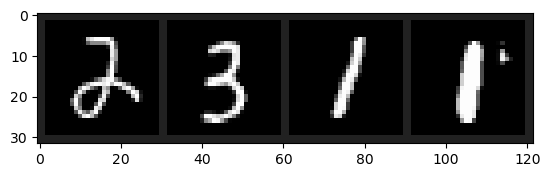

Labels:      2             3             1             1 

Image shape (number of channels, height, width): (1, 28, 28)


In [7]:
# functions to show an image
def imshow(img):
    img = img * STD_MNIST[0] + MEAN_MNIST[0]  # Proper unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # MNIST is grayscale + original tensor shape is (1,28,28) so  np.transpose(img, (1, 2, 0)) gets it to shape (28,28,1) 
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:     ','             '.join(f'{labels[j]}' for j in range(4)), '\n')
print(f'Image shape (number of channels, height, width): {tuple(images[0].shape)}')

In [17]:
images.shape

torch.Size([4, 1, 28, 28])

## Load model


In [8]:
import archis
model = archis.SimpleCNN(input_channels=1, output_channels=10)
model.load_state_dict(torch.load('Models\MNISTsmall.pth'))
model.to(device)
model.eval()

SimpleCNN(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1690, out_features=10, bias=True)
)

## Example of attack

In [9]:
x_batch, y_batch = next(iter(trainloader)) #x_batch is of dimension [B, C, H, W] = [512, 1, 28, 28]. Elements of it (like x_batch[0]) are of dimension [C, H, W] = [1, 28, 28].
x_single = x_batch[0].unsqueeze(0)  # Add batch dimension back (shape: [1, C, H, W])


x_single = x_single.to(device)
output = model(x_single)

In [10]:
x_batch = x_batch.to(device)

In [15]:
import utils
x_adv_1 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=1, total_budget=100)
x_adv_2 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=10, total_budget=100)
x_adv_3 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=30, total_budget=100)
x_adv_4 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=100, total_budget=100)

In [24]:
x_adv_1 = x_adv_1.to('cpu')
x_adv_2 = x_adv_2.to('cpu')
x_adv_3 = x_adv_3.to('cpu')
x_adv_4 = x_adv_4.to('cpu')
x_single = x_single.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


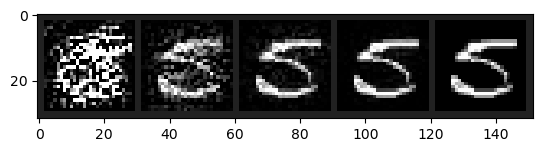

In [25]:
adversarial_examples = torch.cat((x_adv_1, x_adv_2, x_adv_3, x_adv_4, x_single), dim=0)
imshow(torchvision.utils.make_grid(adversarial_examples))

In [13]:
x_adv_batch = utils.ocf_attack(model, x_batch, nb_steps=4, total_budget=20)

## Attack performance